In [4]:
from scipy.special import expit
import numpy as np
import tensorly as tl
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from utils_binaryTensor_Sarah import (TensorModelWithGenetics, generate_survival_data,plot_genetic_effects_over_time, plot_gene_heatmap,
                                      plot_average_gene_effects, plot_basis_functions,
                                      plot_disease_probabilities, plot_survival_times)



In [5]:
N, P, D, K, R1, R2, T = 1000, 20, 5, 4, 3, 3, 50

# Generate synthetic data
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()

theta_true = true_model.compute_theta()
pi_true = expit(theta_true)

G = true_model.G # the genetic covariates for each individual
U2 = true_model.U2
U3 = true_model.U3
W=true_model.W
U1G = true_model.compute_U1G()
# Compute lambda_k and phi
lambda_k = tl.tenalg.mode_dot(U1G, true_model.U2, 2)
phi = tl.tenalg.mode_dot(true_model.W, true_model.U3, 2)
# Compute theta
Y, S = generate_survival_data(pi_true, N, D, T)

# generate binary outcomes
error = np.random.logistic(scale = 1, loc = 0, size = (N, D, T))
Y_binary = ((theta_true + error)>0).astype('int')
model=true_model

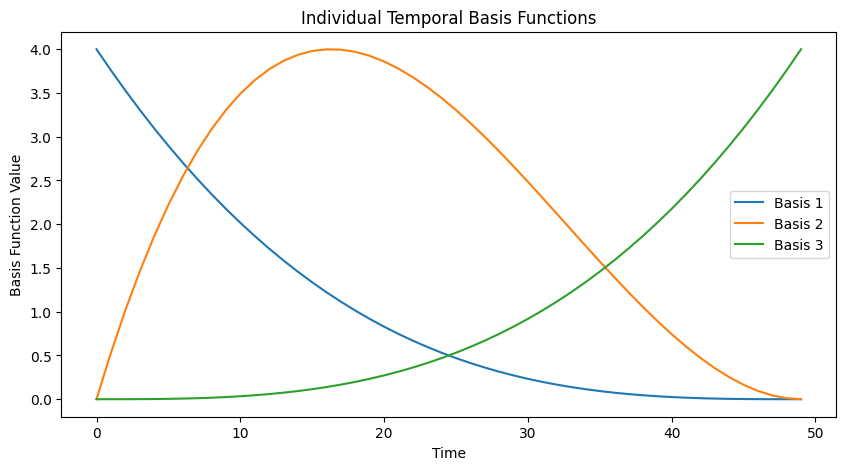

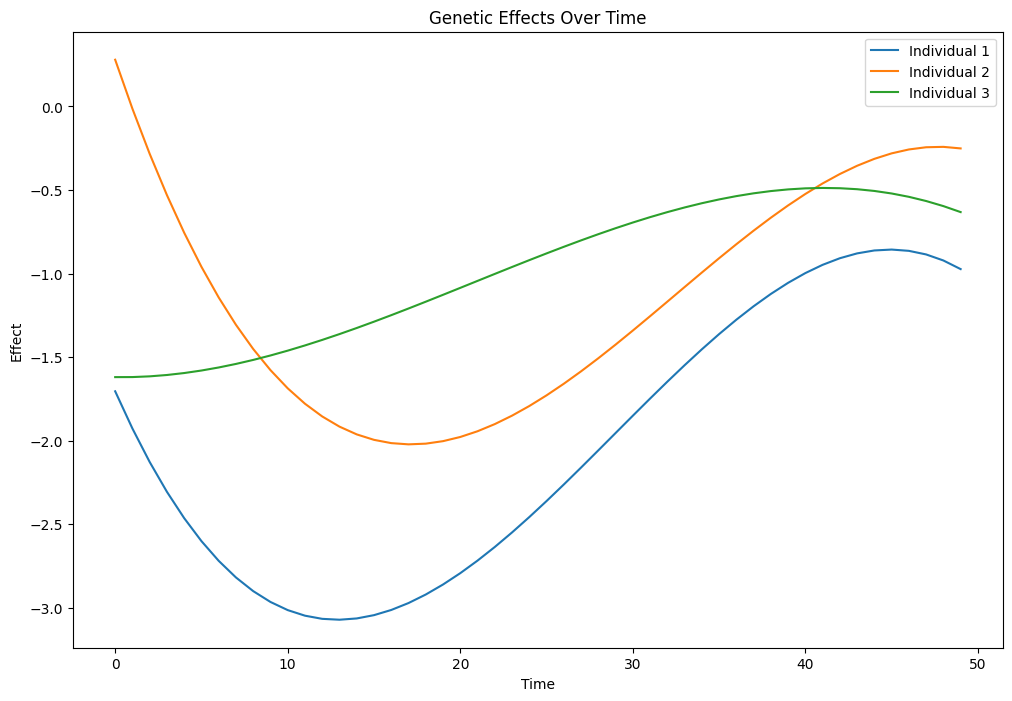

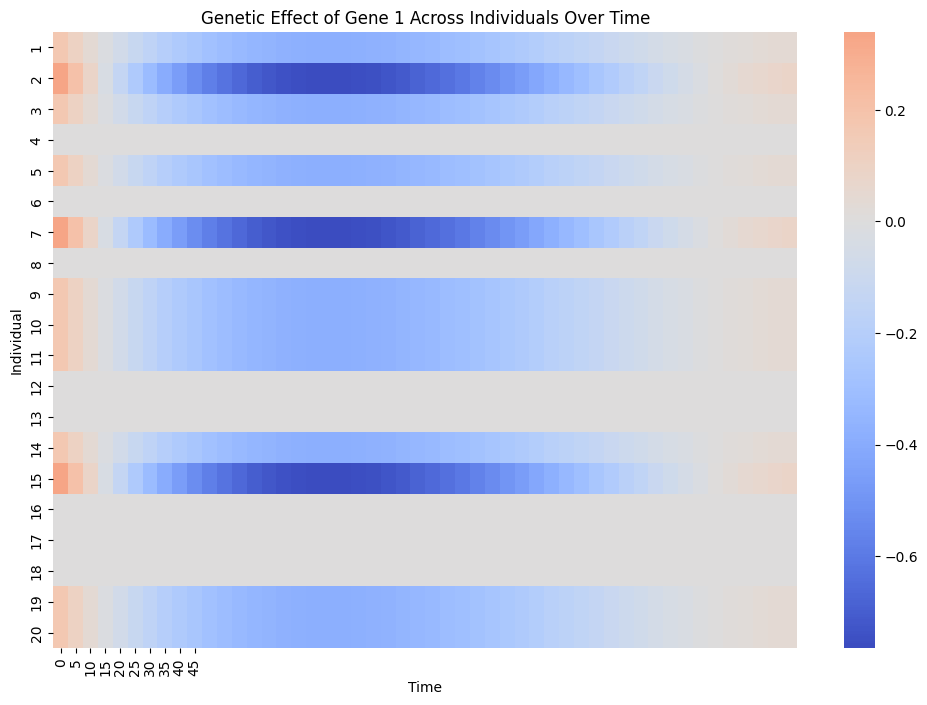

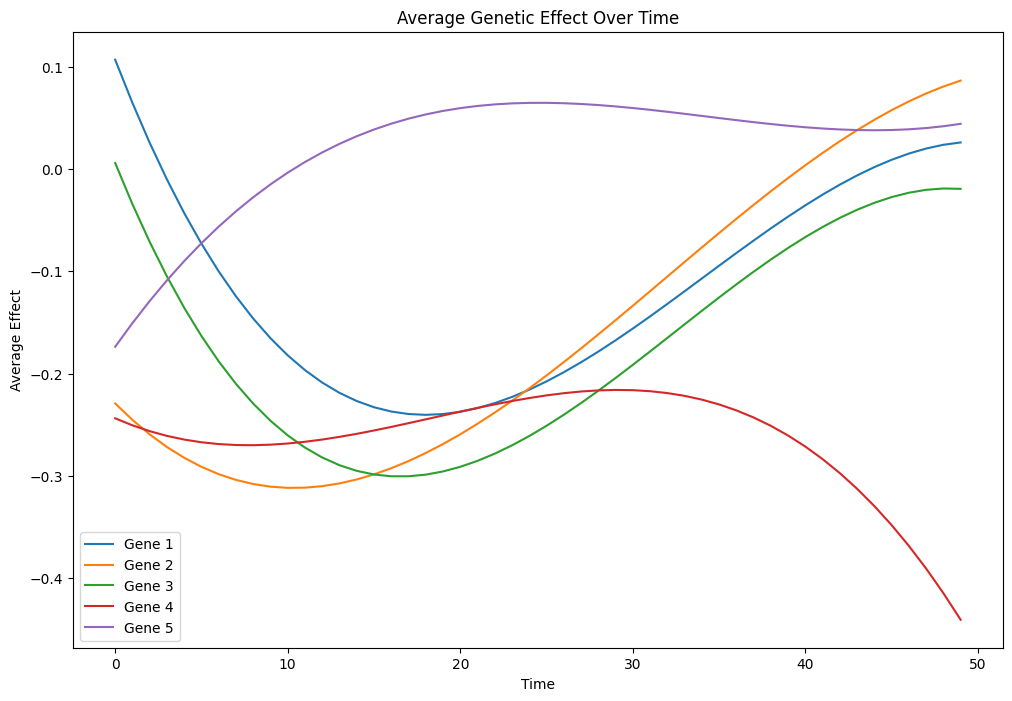

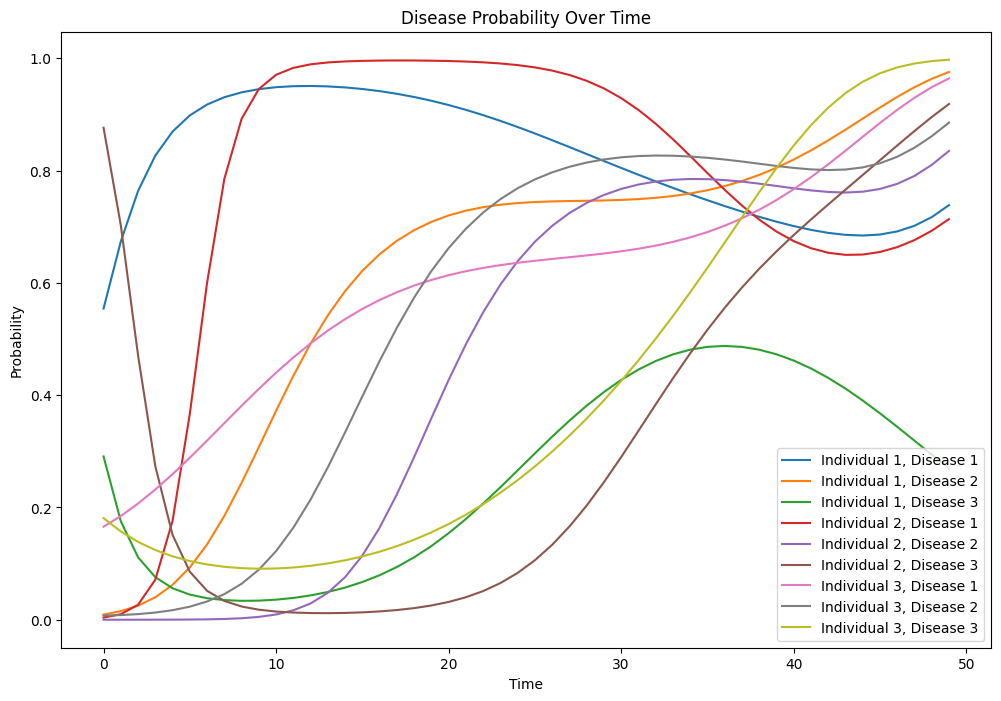

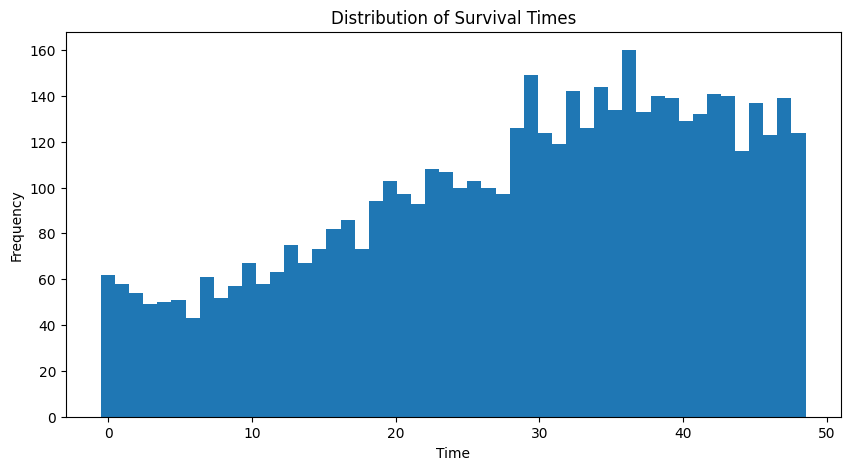

In [6]:

plot_basis_functions(model)
plot_genetic_effects_over_time(model)
plot_gene_heatmap(model, gene_index=0)
plot_average_gene_effects(model)
plot_disease_probabilities(model, pi_true)
plot_survival_times(S, T)


Ok now we want to fit the model to the data using  the inference of Chenyin.

In [7]:
model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)

# Generate data (or use your existing data)
theta_true = model.compute_theta()
pi_true = expit(theta_true)
Y, S = generate_survival_data(pi_true, N, D, T)


In [8]:
# Known parameters
G_known = true_model.G
C_known = true_model.C
U2 = true_model.U2
U3 = true_model.U3

 A1 and A2 in previous code: 

A1 (N x K) represents the average individual loadings across all time points.
A2 (D x K) represents the average disease loadings across all time points.
These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
 Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

We will call these U1G_init and W_init. 

In [9]:
# Initialize B and W
# Initialize U1G and W
U1G_init, w, W_init = svds(Y.mean(axis=2), k=K)
U1G_init = U1G_init @ np.diag(np.sqrt(w))
W_init = (np.diag(np.sqrt(w)) @ W_init).T


Now e'll project U1G_init onto the space spanned by the covariates (G) and the temporal basis (U2) first, and then solve for B. Here's the corrected initialization part:


In [10]:
# Project U1G_init onto the space spanned by the covariates and temporal basis
U1G_init = np.repeat(U1G_init[:, :, np.newaxis], T, axis=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, np.linalg.pinv(U2.T @ U2) @ U2.T, mode=2)
U1G_init = tl.tenalg.mode_dot(U1G_init, G_known @ np.linalg.pinv(G_known.T @ G_known) @ G_known.T, mode=0)


Now we can come up with an initial guess for B. 
```
For each r in R1, we're solving the equation:
U1G_init[:, :, r] = G_known @ B[:, :, r] + C_known[:, :, r]
Rearranging this:
G_known @ B[:, :, r] = U1G_init[:, :, r] - C_known[:, :, r]
Now, we're solving this equation using the least squares method. In mathematical notation:
B[:, :, r] = argmin_B ||G_known @ B - (U1G_init[:, :, r] - C_known[:, :, r])||^2
Where:
B[:, :, r] is a P x K matrix (for each r)
G_known is an N x P matrix
U1G_init[:, :, r] is an N x K matrix (for each r)
C_known[:, :, r] is an N x K matrix (for each r)
The np.linalg.lstsq function is solving this least squares problem. It's finding the B that minimizes the squared Euclidean 2-norm ||G_known @ B - (U1G_init[:, :, r] - C_known[:, :, r])||^2.
```

In [14]:
B = np.zeros((P, K, R1))
for r in range(R1):
    B[:, :, r] = np.linalg.lstsq(G_known, U1G_init[:, :, r] - C_known[:, :, r], rcond=None)[0]


Similarly, project W onto the space spanned by the temporal basis

In [15]:
print(U1G_init.shape)
print(B.shape)
print(W_init.shape)


(1000, 4, 3)
(20, 4, 3)
(5, 4)


In [16]:
W = tl.tenalg.mode_dot(np.repeat(W_init[:, :, np.newaxis],T, axis=2),
                       np.linalg.pinv(U3.T @ U3) @ U3.T, mode=2)

print(W.shape)

(5, 4, 3)


In [17]:
# Optimization parameters
stepsize = 0.1
alpha = 0.5
beta = 0.8
stepsize_B = stepsize_W = stepsize
niters = 1000
t_idx = len(Y.shape) - 1

def survival_likelihood(Y, S, theta):
    pi = expit(theta)
    log_likelihood = 0
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
            if Y[n, d, t] == 1:
                log_likelihood += np.log(pi[n, d, t] + 1e-10)
    return log_likelihood


1. Model structure: U1G = G @ B + C
Known components:
G (genetic data)
C (non-genetic effects)
Unknown component:
B (genetic effects)
4. Optimization focus:
Since G and C are known, the only part of U1G that we need to optimize is B. This is why we're updating B directly in each iteration.

Gradient computation:
When we compute the gradient for B, we're essentially asking, "How should we change B to improve our model's fit, given the fixed G and C?"
6. Updating process:
We update B based on its gradient.
Then we recompute U1G using the updated B and the fixed G and C.
This new U1G is used to compute the new theta and evaluate the model's performance.
This approach allows us to:
Maintain the correct structure of U1G throughout the optimization.
Focus our optimization efforts solely on the unknown genetic effects (B).
Incorporate our knowledge of the non-genetic effects (C) without trying to re-estimate them.
```
U1G = G @ B + C
θ = λ_k ⊗ φ = (U1G ⊗1 U2) ⊗ (W ⊗_2 U3)
We want to find ∂L/∂B, where L is our loss function.
Using the chain rule:
∂L/∂B = ∂L/∂θ ∂θ/∂U1G ∂U1G/∂B
1. ∂L/∂θ is our L_nabla
∂θ/∂U1G = U2 ⊗ φ
∂U1G/∂B = G^T
Putting this together:
∂L/∂B = G^T @ [(L_nabla ⊗3 U2^T) ⊙ φ]
Where ⊙ is the Hadamard (element-wise) product.
In code, this translates to:
```


In [18]:

for it in range(niters):
    # Compute time-varying versions
    U1G = np.einsum('np,pkr->nkr', G_known, B) + C_known
    lambda_k = np.einsum('nkr,tr->nkt', U1G, U2)
    phi = np.einsum('dkr,tr->dkt', W, U3)
    
    theta_pre = np.einsum('nkt,dkt->ndt', lambda_k, phi)
    
    # Unfold along the first and second modes at each time

    L_nabla = np.zeros_like(theta_pre)
    pi = expit(theta_pre)
    for n in range(N):
        for d in range(D):
            t = S[n, d]
            L_nabla[n, d, :t] = -pi[n, d, :t]
            if Y[n, d, t] == 1:
                L_nabla[n, d, t] += 1

    # Unfold along the first and second modes at each time
    # Unfold along the first and second modes at each time
    L_nabla_mode0 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=0) for 
                            idx in range(L_nabla.shape[t_idx])], axis=t_idx)
    L_nabla_mode1 = np.stack([tl.unfold(L_nabla[:, :, idx], mode=1) for 
                            idx in range(L_nabla.shape[t_idx])], axis=t_idx)

    # Compute loss
    loss_pre = -survival_likelihood(Y, S, theta_pre)
    
    print("L_nabla_mode1 shape:", L_nabla_mode1.shape)
    print("lambda_k shape:", lambda_k.shape)
    print("L_nabla_mode0 shape:", L_nabla_mode0.shape)
    print("phi shape:", phi.shape)

    # Compute gradients
    grad_W = tl.tenalg.mode_dot(np.einsum('ijt,jkt->ikt', L_nabla_mode1, lambda_k),
                            U3.T, 2)

# Compute gradient for B
    grad_U1G = tl.tenalg.mode_dot(np.einsum('jit,ikt->jkt', L_nabla_mode0, phi),
                              U2.T, 2)  # Shape: (N, K, R1)
    grad_B = np.einsum('nkr,np->pkr', grad_U1G, G_known)  # Shape: (P, K, R1)


    
    # Update parameters
    W_tilde = W - stepsize_W * grad_W
    B_tilde = B - stepsize_B * grad_B

    # Compute new theta
    U1G_tilde = np.einsum('np,pkr->nkr', G_known, B_tilde) + C_known
    lambda_k_tilde = np.einsum('nkr,tr->nkt', U1G_tilde, U2)
    phi_tilde = np.einsum('dkr,tr->dkt', W_tilde, U3)
    theta_after = np.einsum('nkt,dkt->ndt', lambda_k_tilde, phi_tilde)
    
    # Compute new loss
    loss_after = -survival_likelihood(Y, S, theta_after)

    # Backtracking line search
    while loss_after > loss_pre - alpha * (stepsize_W * np.linalg.norm(grad_W)**2 + 
                                           stepsize_B * np.linalg.norm(grad_B)**2):
        stepsize_W *= beta
        stepsize_B *= beta
        W_tilde = W - stepsize_W * grad_W
        B_tilde = B - stepsize_B * grad_B
        U1G_tilde = np.einsum('np,pkr->nkr', G_known, B_tilde) + C_known
        lambda_k_tilde = np.einsum('nkr,tr->nkt', U1G_tilde, U2)
        phi_tilde = np.einsum('dkr,tr->dkt', W_tilde, U3)
        theta_after = np.einsum('nkt,dkt->ndt', lambda_k_tilde, phi_tilde)
        loss_after = -survival_likelihood(Y, S, theta_after)
    
    # Update parameters
    W = W_tilde
    B = B_tilde
    
    if it % 10 == 0:
        print(f"Iteration {it}, Loss: {loss_after}")
    
    if np.abs(loss_pre - loss_after) / np.abs(loss_pre) < 1e-5:
        print("Converged!")
        break
    

L_nabla_mode1 shape: (5, 1000, 50)
lambda_k shape: (1000, 4, 50)
L_nabla_mode0 shape: (1000, 5, 50)
phi shape: (5, 4, 50)
Iteration 0, Loss: 91180.91951817686
Converged!
